In [259]:
import sys
import os

path = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, path + '/../')

from util.io import log_files
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('paper')

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import tikzplotlib

_ = importlib.reload(log_files)

In [253]:
logs = {
    'CartPole': '/Users/florentdelgrange/workspace/logs/02-08-21/CartPole-v0',
    'MountainCar': '/Users/florentdelgrange/workspace/logs/02-08-21/MountainCar-v0',
    'Acrobot': '/Users/florentdelgrange/workspace/logs/30-07-21//AcrobotRandomInit-v1',
    'Pendulum': '/Users/florentdelgrange/workspace/logs/02-08-21/PendulumRandomInit-v0/*/*/*',
    # 'LunarLanderContinuous': ,#
}

df = None

for env, log_dir in logs.items():
    _df = log_files.get_event_dataframe(
        log_dir,
        tags=['eval_elbo', 'local_reward_loss', 'local_probability_loss', 'encoder_entropy',
              'state_encoder_entropy', 'policy_evaluation_avg_rewards', 'action_encoder_entropy',
              'eval_rate', 'eval_distortion'],
        run_name='prioritized replay',
        event_name=env,)
    df = _df if df is None else df.append(_df)
        

In [155]:
importlib.reload(log_files)

logs['CartPole_uniform'] = "/Users/florentdelgrange/workspace/logs/05-07-21/CartPole-v0/*11111*[!PER]*"
logs['MountainCar_uniform'] = "/Users/florentdelgrange/workspace/logs/05-07-21/MountainCar-v0/*11111*[!PER]*"

hist = None
for environment in ['CartPole', 'MountainCar']:
    _df = log_files.get_event_dataframe(
    os.path.join(logs[environment], '*11111*PER*'),
    regex='**',
    tags=['state_frequency'],
    run_name='prioritized',
    event_name=environment,
    value_dtype=None)
    _df = _df.append(
        log_files.get_event_dataframe(
            logs[environment + '_uniform'],
            regex='**',
            tags=['state_frequency'],
            run_name='uniform',
            event_name=environment,
            value_dtype=None))
    hist = _df if hist is None else hist.append(_df)

hist = hist[hist['step'] <= int(1e6)]

# Evaluation

The goal of our experiments is to evaluate the quality of the latent space model learned and the policy distilled via our Variational MDP framework. This evaluation consists in
1. an analysis of the training of the latent space model via our variational objective, i.e., the local ELBO, and the benefits of our method to avoid posterior collapse,
2. testing the performance (in terms of rewards) of the distilled policy in $\mdp$ to asses if the latent space model learned allows for a successful compression of the state-action space that retains the necessary information for optimizing the return, and
3. computing (PAC) upper bounds on local losses to asses the quality the abstraction learned.

We evaluate our method on classic OpenAI environments (cite) with continuous states and discrete actions (CartPole, MountainCar, and Acrobot) and on environments with continuous states and actions (Pendulum and LunarLander). We distill RL policies learned through DQN (cite) for environments with discrete actions, and SAC (cite) for environments with continuous actions.
For each line plot, we train five different instances of our VAE with different random seeds, where the solid line corresponds to the median and the confidence interval (shaded) to the interquartile range.

## Learning Setup

**Move the discrete latent distribution subsection here.** Intuitively, they rely on a temperature parameter $\lambda$ that makes the continuous distributions converging to their discrete variant when $\lambda$ converges to $0$.

**Behavioral models.** For $\decoder^{\generative}$, $\embeda_{\encoderparameter, \decoderparameter}$, and $\decoder^{\rewards}$, we learn the parameters of multivariate normal distributions.
Notice $\decoder^{\generative}$, $\embeda_{\encoderparameter, \decoderparameter}$ thus allows generating grounded states or actions from the environment based on their latent embedding.
This makes our approach well-suited for representation learning: while we learn a representation of the input model and policy through latent state and action spaces, we can further link each latent state and action with the normal distribution obtained via these generative models.

We use neural networks to optimize the parameters of our variational model using the Adam optimizer, by sampling mini-batches of transitions from the replay buffer.

## Local ELBO optimization


In order to allows the local ELBO to be trained efficiently, posterior collapse has to be tackled from the very first stages of training. In fact, we found that the KL-saling and entropy regularization annealing schemes (cf. Section~\ref{}) were necessary to avoid the latent space to collapse to a single state-action pair after only a few training steps.

We found the most efficient to start with an autoencoder ($\beta_0=0$) and a large entropy regularizer (e.g., $\alpha_0=10$) during the $10^4$ first steps, and then anneal them via $\alpha_x = \alpha_0 \cdot (1 - \tau)^x$, $\beta_x = 1 - (1 - \tau)^x$ (e.g., $\tau = 10^{-5}$) to fully recover the local ELBO objective around the middle of the training.
We also found that prioritized experience replay can be used to avoid posterior collapse. This is illustrated in Figure~\ref{}

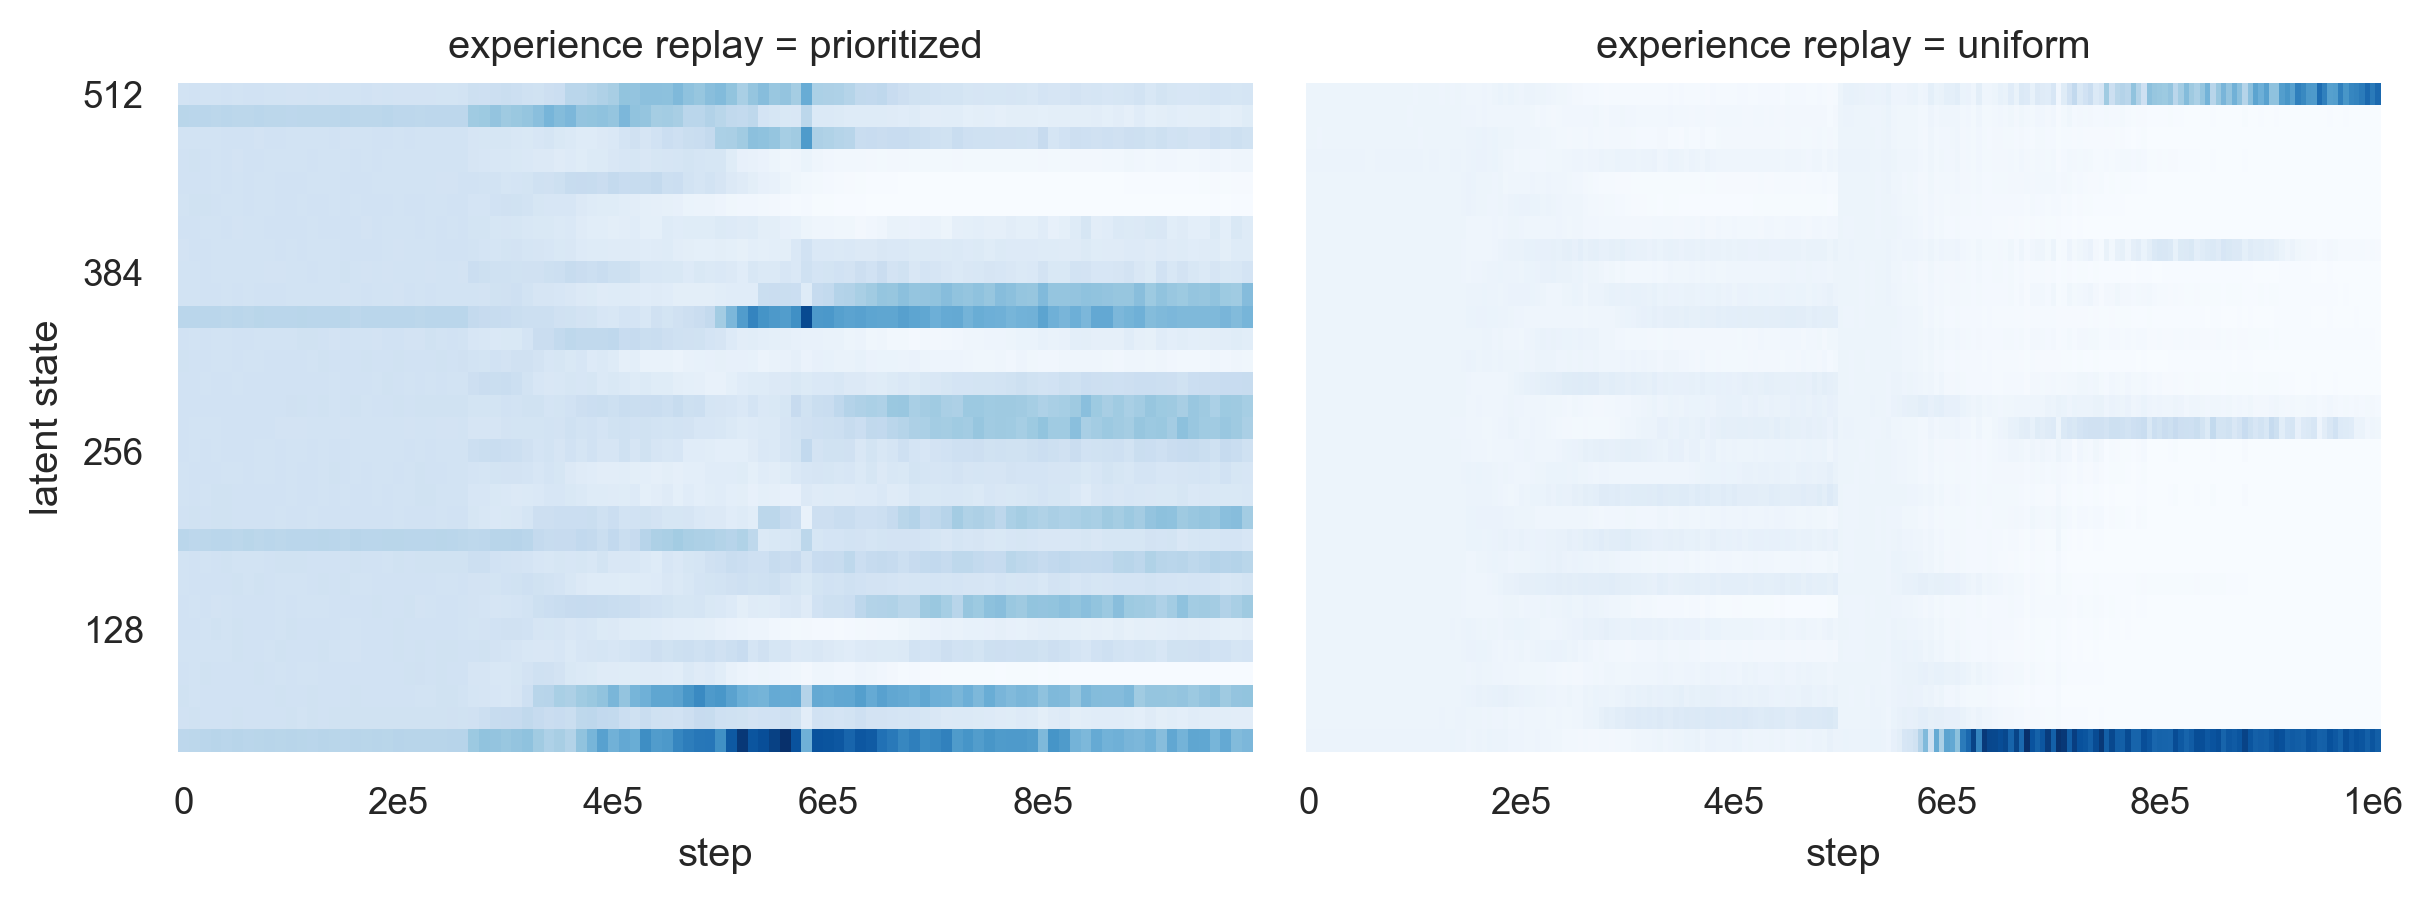

In [246]:
importlib.reload(log_files)

plt.rcParams['figure.dpi'] = 300

# g = log_files.plot_histograms_per_step(hist, num_x_ticks=5, num_y_ticks=4)
g = log_files.plot_histograms_per_step(hist[hist['event'] == 'CartPole'], num_x_ticks=5, num_y_ticks=4, aspect=2.8)
tikzplotlib.save("cartpole_histogram.tex")

*Evolution of the latent state space distribution along training steps for the CartPole environment. The intensity of the blue hue corresponds to the latent states produced by $\embed$ during the local ELBO optimization. We compare a bucket-based prioritized against a simple uniform experience replay. The latent space learned with transitions sampled from the uniform replay buffer collapses to two latent states.*

Figure~\ref{} shows that training the ELBO this way results in a stable learning procedure that successfully minimizes the distortion while preventing an auto-decoding behavior by keeping the rate away from $0$.

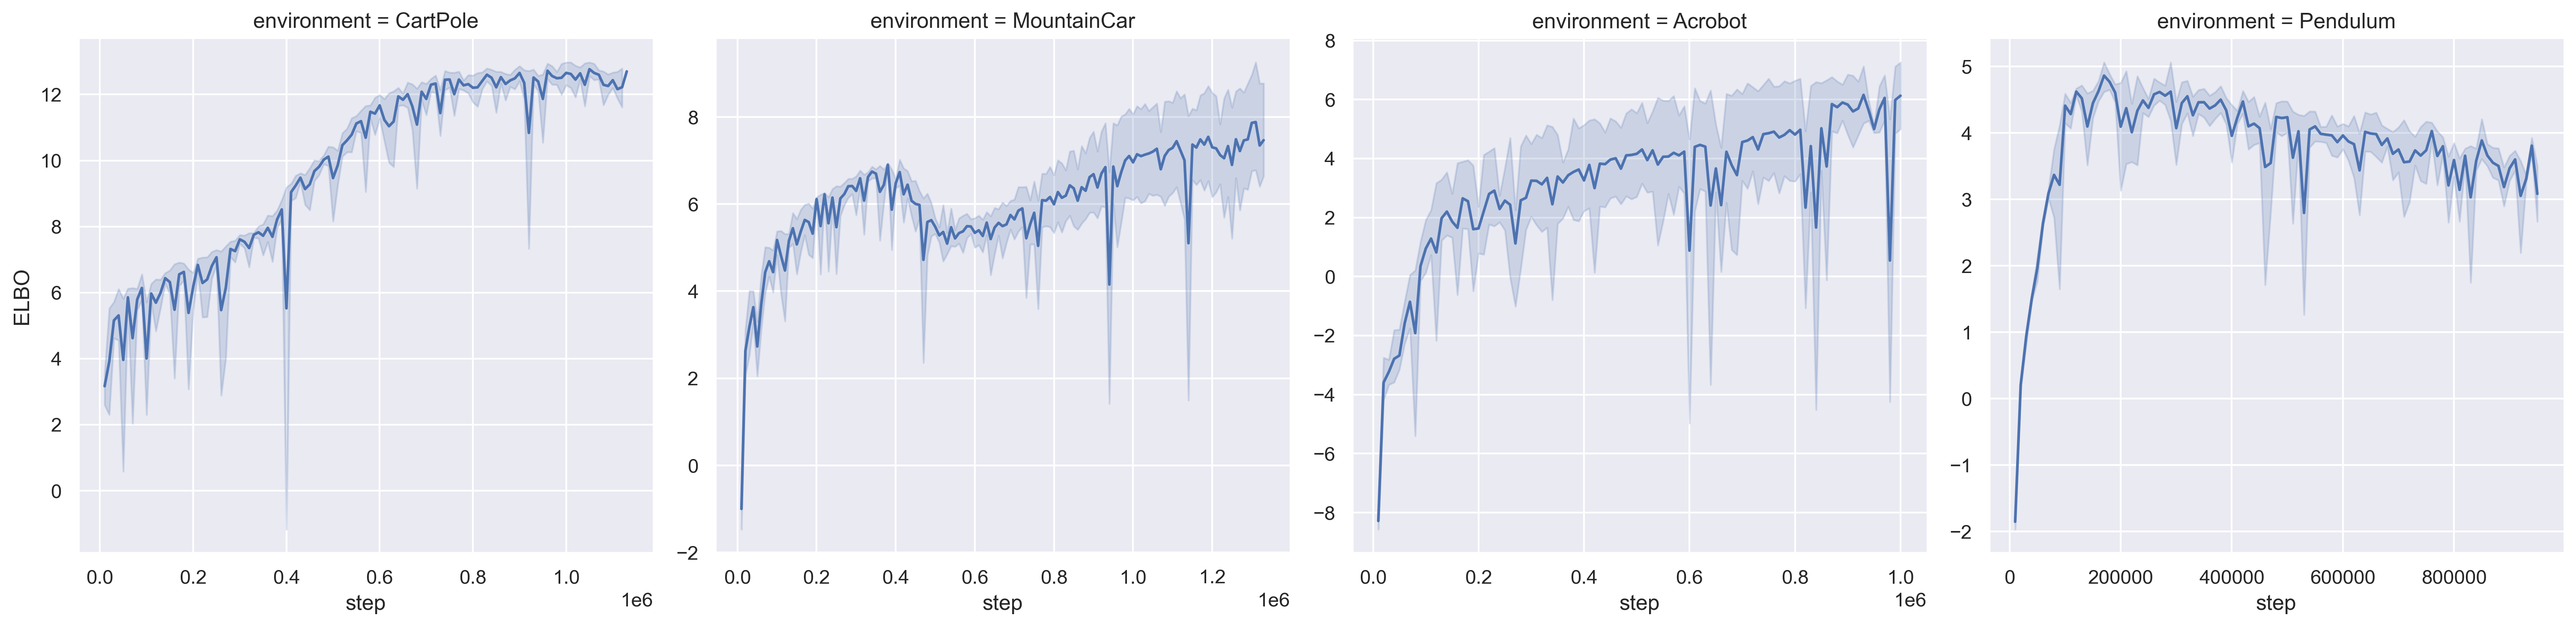

In [99]:
log_files.plot_elbo_evaluation(df, compare_environments=True, aspect=1, relplot=True)
tikzplotlib.save("eval_elbo.tex")

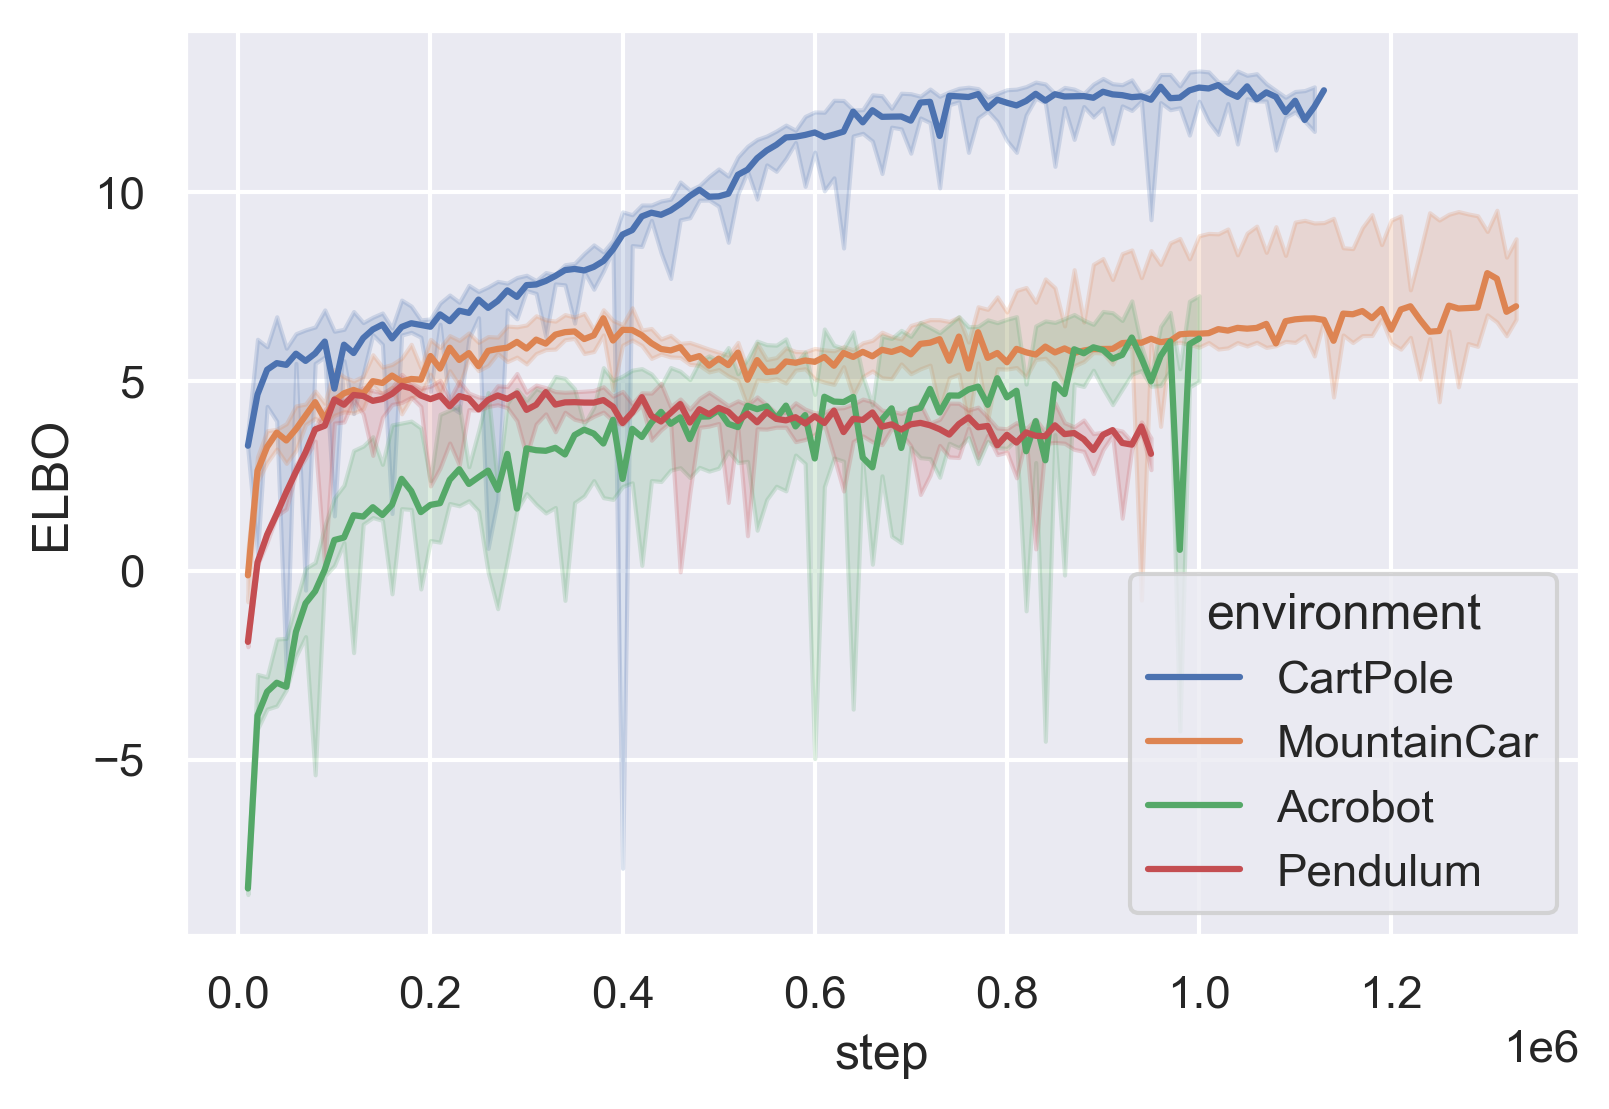

In [260]:
importlib.reload(log_files)

log_files.plot_elbo_evaluation(df, compare_environments=True, aspect=1, relplot=False, estimator='median')
tikzplotlib.save("eval_elbo_single.tex")

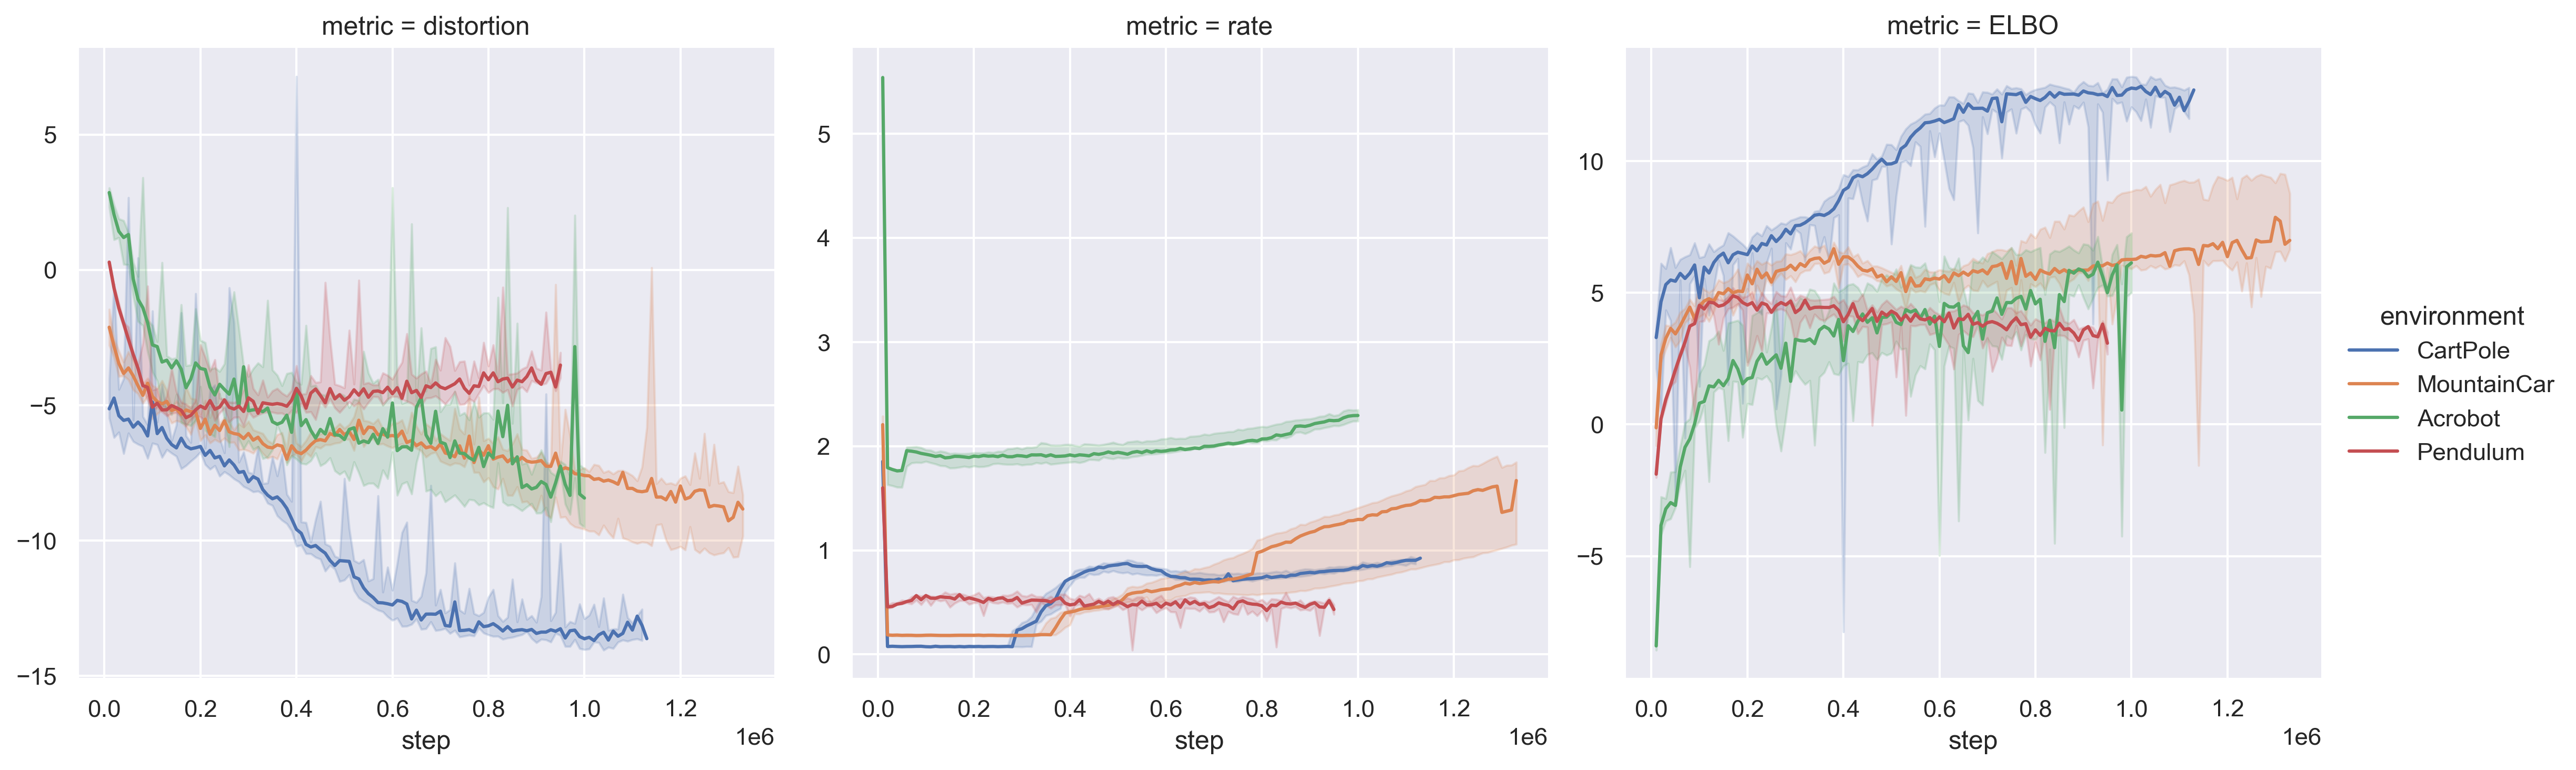

In [262]:
estimator = {'mean': 'mean', 'median': np.median}
estimator = estimator['median']

_df = df[df['tag'] == 'eval_distortion']
_df = _df.append(df[df['tag'] == 'eval_rate'])
_df = _df.append(df[df['tag'] == 'eval_elbo'])

g = sns.relplot(
    data=_df.replace(
        {'tag': {'eval_distortion': 'distortion', 'eval_rate': 'rate', 'eval_elbo': 'ELBO'}}
    ).rename(columns={'tag': 'metric', 'event': 'environment'}),
    x='step',
    y='value',
    hue='environment',
    col='metric',
    estimator=estimator,
    ci=90 if estimator != 'mean' else 'sd',
    legend='brief',
    facet_kws=dict(sharey=False),
    kind='line',
    seed=42)

#g.set(yticklabels = [])
g.set(ylabel=None)
tikzplotlib.save("distortion_rate_elbo.tex")

*Plots reporting $\distortion$, $\rate$, and $\ELBO$ for different environments. The metrics are approximated over a large batch (10 times the batch size used during training) sampled from the replay buffer, and averaged using importance sampling weights. We used the discrete latent distributions for this evaluation.*

## Deterministic embedding functions

The VAE framework requires to train a stochastic encoder $\encoder$ to optimize the ELBO (cf. Sect.~\ref{}).

In order to use $\tuple{\embed_{\encoderparameter}, \embeda_{\encoderparameter, \decoderparameter}}$ as deterministic embedding functions, we need to make sure that taking the mode of $\embed_{\encoderparameter}, \embeda_{\encoderparameter, \decoderparameter}$ is consistent with the local ELBO of the variational model reported.
Figure~\ref{} illustrates that the entropy of $\embed_{\encoderparameter}$ and $\encoder^{\actions}$ converges to a low value for all environments, which agrees with assumption.

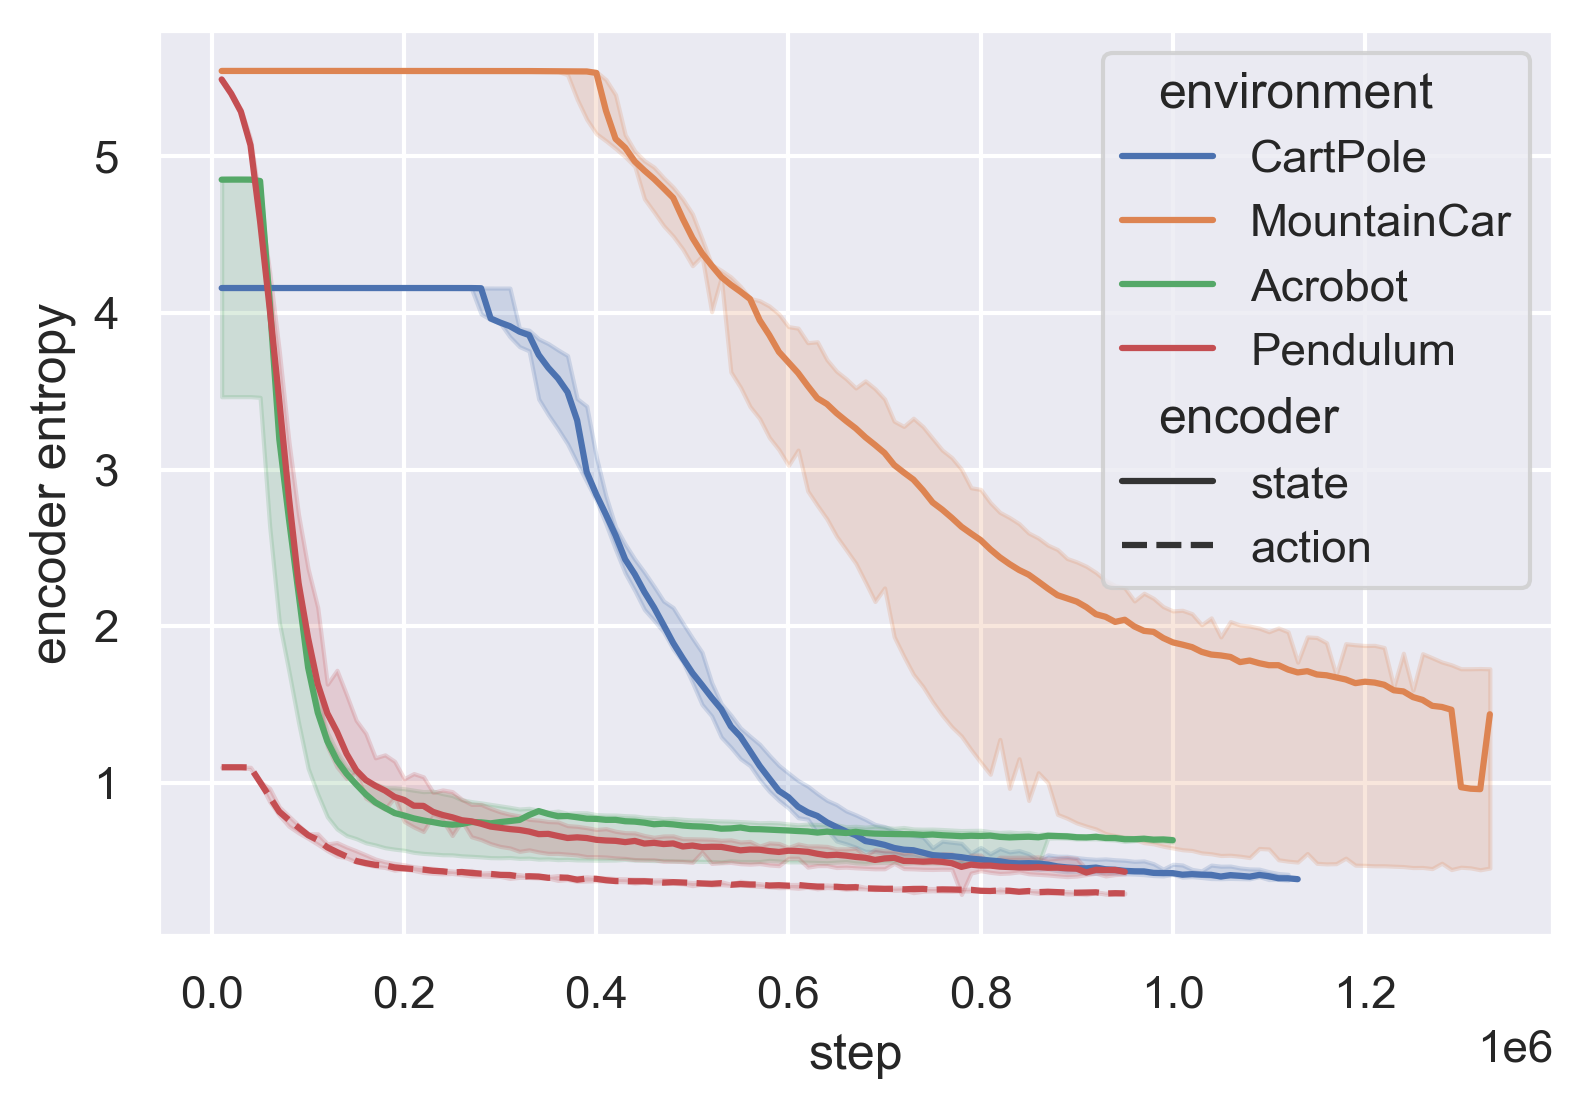

In [125]:
_df1 = df[df['event'] != 'Pendulum']
_df1 = _df1[_df1['tag'] == 'encoder_entropy']
_df2 = df[df['event'] == 'Pendulum']
_df3 = _df2[_df2['tag'] == 'state_encoder_entropy']
_df2 = _df3.append(_df2[_df2['tag'] == 'action_encoder_entropy'])
_df = _df1.append(_df2)
_df['tag'] = _df['tag'].replace({
    'encoder_entropy': 'state',
    'state_encoder_entropy': 'state',
    'action_encoder_entropy': 'action'})

estimator = {'mean': 'mean', 'median': np.median}
estimator = estimator['median']

sns.lineplot(
    data=_df[_df['step'] % int(1e4) == 0].rename(
        columns={
            "value": "encoder entropy",
            "event": "environment",
            "tag": "encoder"}),
    x='step',
    y='encoder entropy',
    hue="environment",
    style="encoder",
    legend='brief',
    estimator=estimator,
    ci=90 if estimator != 'mean' else 'sd')
tikzplotlib.save("encoder_entropy.tex")

*Entropy of the discrete latent distribution. The latter is exactly computed from the discrete distribution learned (Bernoulli or Categorical).*

## Policy distilation

In order to evaluate if the distilled policy $\latentpolicy$ offers a valid representation of the input RL policy $\policy$ in terms of performance, we compare the return achieved by $\latentpolicy$ against $\policy$ in the RL environment. Figure~\ref{} illustrates that similar performance can be achieved by executing $\latentpolicy$ in $\mdp$. 
Moderate return gap sometimes appears (e.g., in Pendulum or LunarLander) but corresponds to precision loss caused by the asbtraction induced by the latent space while maintaining similar and acceptable behaviors.

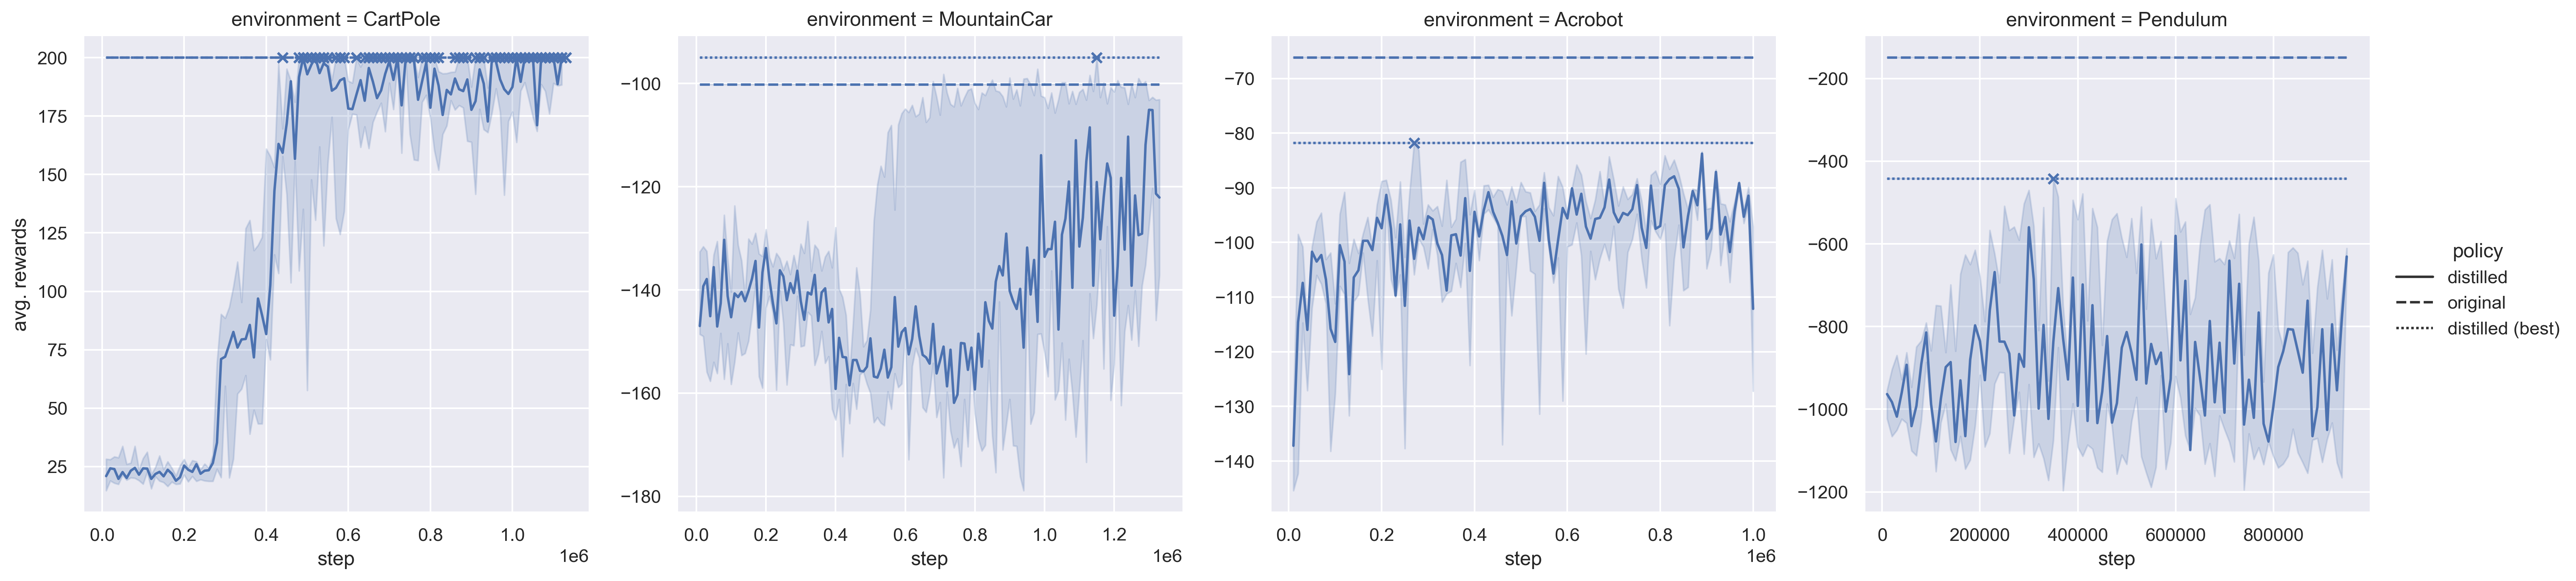

In [120]:
importlib.reload(log_files)

g = log_files.plot_policy_evaluation(
    df,
    plot_best=True,
    original_policy_expected_rewards={
        'CartPole': 200,
        'MountainCar': -100.2,
        'Acrobot': -66.2,
        'Pendulum': -149.77565,
    },
    compare_environments=True,
    aspect=1,
    relplot=True,
    estimator='median')


tikzplotlib.save("eval_policy.tex")

*Plots reporting the expected return $\expected_{\latentpolicy}^{\mdp}{\discount_{1}}$ where $\mdp$ models the environment. The former is averaged over $30$ episodes in the environment.*

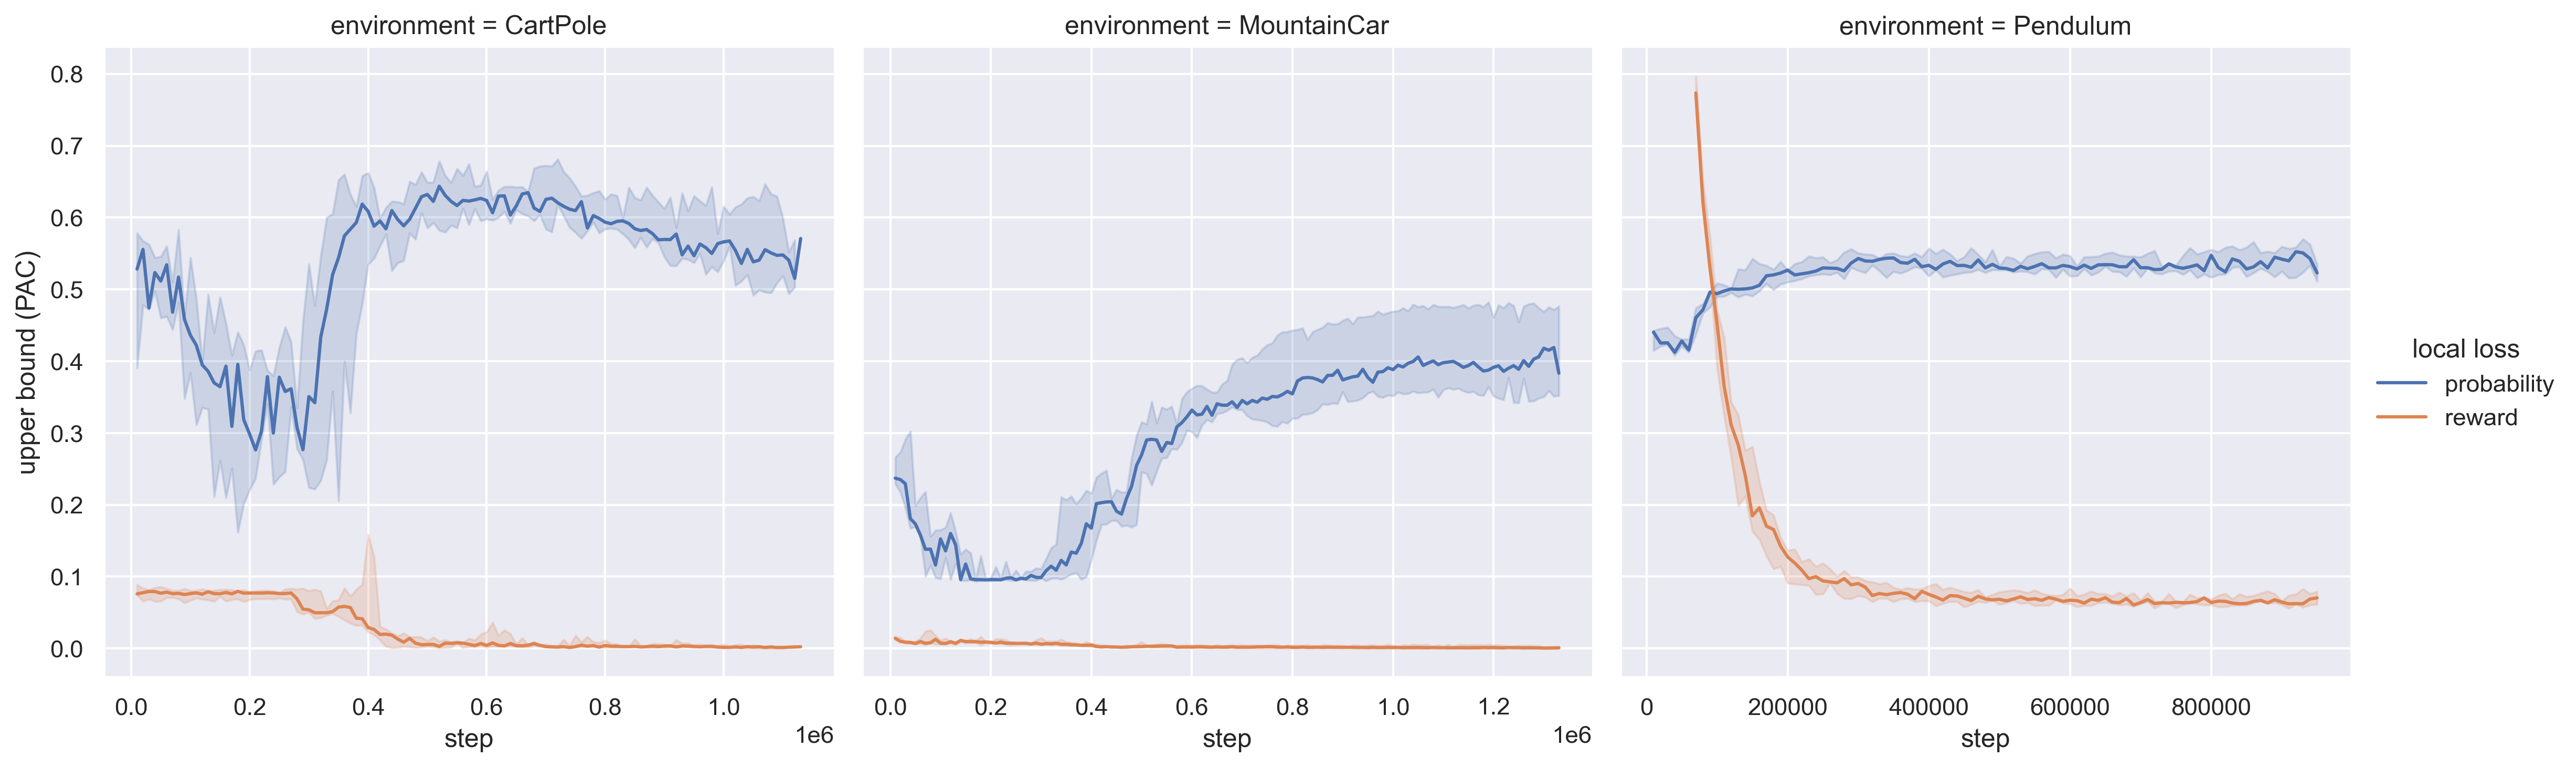

In [142]:
_df = df[df['tag'] == 'local_probability_loss']
_df = _df.append(df[df['tag'] == 'local_reward_loss'])
_df = _df[_df['value'] <= 1]
_df = _df.replace({
        'tag': {'local_probability_loss': 'probability',
                'local_reward_loss': 'reward'}}
    ).rename(columns={
        'tag': 'local loss',
        'value': 'upper bound (PAC)',
        'event': 'environment'})

estimator = {'mean': 'mean', 'median': np.median}
estimator = estimator['median']

sns.relplot(
    data=_df.replace({
        'tag': {'local_probability_loss': 'probability',
                'local_reward_loss': 'reward'}}
    ).rename({
        'tag': 'local loss',
        'value': 'upper bound (PAC)'}),
    x='step',
    y='upper bound (PAC)',
    col='environment',
    hue='local loss',
    kind='line',
    facet_kws=dict(sharex=False),
    estimator=estimator,
    ci=90 if estimator != 'mean' else 'sd')

tikzplotlib.save("local_losses.tex")